<a href="https://colab.research.google.com/github/jychen630/dl-fall22-mini-project/blob/main/Dennis_Mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install -e git+https://github.com/marcoancona/TorchPruner.git#egg=torchpruner

In [3]:
import ssl
def set_up_ssl():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

set_up_ssl()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.utils.prune as prune
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

import os
import sys
import time
import math
import argparse
import humanize
import numpy as np
import matplotlib.pyplot as plt

In [5]:
term_width = 5
TOTAL_BAR_LENGTH = 7
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

In [6]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        # pruning model parameters in the first convolution layer

        # prune.random_unstructured(self.conv1, name='weight', amount=0.6)
        # prune.remove(self.conv1, 'weight')

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        # pruning model parameters in the second convolution layer

        # prune.random_unstructured(self.conv2, name='weight', amount=0.6)
        # prune.remove(self.conv2, 'weight')

        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)

        # prune.random_unstructured(self.conv1, name='weight', amount=0.5)
        # prune.remove(self.conv1, 'weight')

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        
        # prune.random_unstructured(self.conv2, name='weight', amount=0.5)
        # prune.remove(self.conv2, 'weight')

        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        
        # prune.random_unstructured(self.conv3, name='weight', amount=0.5)
        # prune.remove(self.conv3, 'weight')

        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        
        # prune.random_unstructured(self.conv1, name='weight', amount=0.5)
        # prune.remove(self.conv1, 'weight')

        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # removing the 4th layer to reduce the size of the network
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

        # prune.random_unstructured(self.linear, name='weight', amount=0.5)
        # prune.remove(self.linear, 'weight')

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # removing the 4th layer to reduce the size of the network
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


#seems not used
# def test():
#     net = ResNet18()
#     y = net(torch.randn(1, 3, 32, 32))
#     print(y.size())


In [7]:

LOCAL_M1 = False

if LOCAL_M1:
    device = 'cuda' if torch.cuda.is_available() else 'mps'
else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #transforms.RandomErasing()
  
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# constructing validation set

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

torch.manual_seed(43)
val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)
print("The length of a train set is ", len(train_ds))
print("The length of a validation set is ", len(val_ds))
print("The length of a test set is ", len(testset))

trainloader = torch.utils.data.DataLoader(
    train_ds, batch_size=128, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=128, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

net = ResNet18() # 11.2 params
#net = ResNet50() # 23.5

==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
The length of a train set is  45000
The length of a validation set is  5000
The length of a test set is  10000


In [8]:
layers = list(net.children())

print(len(layers))

print("layers[0]: ", layers[0])
print("layers[1]: ", layers[1])
print("layers[2]: ", layers[2])
print("layers[3]: ", layers[3])
print("layers[4]: ", layers[4])
print("layers[5]: ", layers[5])
print("layers[6]: ", layers[6])

7
layers[0]:  Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layers[1]:  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layers[2]:  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [9]:
!git clone https://github.com/VainF/Torch-Pruning.git # recommended
!pip3 install torch_pruning

Cloning into 'Torch-Pruning'...
remote: Enumerating objects: 1833, done.
remote: Counting objects: 100% (688/688), done.
remote: Compressing objects: 100% (314/314), done.
remote: Total 1833 (delta 418), reused 609 (delta 358), pack-reused 1145
Receiving objects: 100% (1833/1833), 3.91 MiB | 9.39 MiB/s, done.
Resolving deltas: 100% (1139/1139), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import torch_pruning as tp

def prune_model(model):
    model.cpu()
    DG = tp.DependencyGraph().build_dependency( model, torch.randn(1, 3, 32, 32) )
    def prune_conv(conv, amount=0.2):
        strategy = tp.strategy.L1Strategy()
        pruning_index = strategy(conv.weight, amount=amount)
        plan = DG.get_pruning_plan(conv, tp.prune_conv_out_channel, pruning_index)
        plan.exec()
    
    block_prune_probs = [0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3]
    blk_id = 0
    for m in model.modules():
        if isinstance( m, BasicBlock):
            prune_conv( m.conv1, block_prune_probs[blk_id] )
            prune_conv( m.conv2, block_prune_probs[blk_id] )
            blk_id+=1
    return model   

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_params(model):
  print("Number of parameters ", humanize.intword(count_parameters(model)))
  return

In [12]:
print("The number of parameters before pruning is ")
print_params(net)

The number of parameters before pruning is 
Number of parameters  11.2 million


In [15]:
prune_model(net)

ResNet(
  (conv1): Conv2d(3, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(44, 53, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(53, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(53, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(44, 53, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(53, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(53, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=

In [16]:
print("The number of parameters after pruning is ")
print_params(net)

The number of parameters after pruning is 
Number of parameters  1.9 million


In [17]:
# from torchpruner import (Pruner, ShapleyAttributionMetric)

In [18]:
def get_pruned_parameters_countget_pruned_parameters_count(pruned_model):
    params = 0
    for param in pruned_model.parameters():
        if param is not None:
            params += torch.nonzero(param).size(0)
    return params

In [19]:
from torchsummary import summary

def print_model_summary(model):
  print(summary(model.to(device), (3, 32, 32)))

print_model_summary(net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 44, 32, 32]           1,188
       BatchNorm2d-2           [-1, 44, 32, 32]              88
            Conv2d-3           [-1, 53, 32, 32]          20,988
       BatchNorm2d-4           [-1, 53, 32, 32]             106
            Conv2d-5           [-1, 44, 32, 32]          20,988
       BatchNorm2d-6           [-1, 44, 32, 32]              88
        BasicBlock-7           [-1, 44, 32, 32]               0
            Conv2d-8           [-1, 53, 32, 32]          20,988
       BatchNorm2d-9           [-1, 53, 32, 32]             106
           Conv2d-10           [-1, 44, 32, 32]          20,988
      BatchNorm2d-11           [-1, 44, 32, 32]              88
       BasicBlock-12           [-1, 44, 32, 32]               0
           Conv2d-13           [-1, 83, 16, 16]          32,868
      BatchNorm2d-14           [-1, 83,

In [20]:
def print_model_layers(model):
  for name, param in model.named_parameters():
    print(name, param.size())

print_model_layers(net)

conv1.weight torch.Size([44, 3, 3, 3])
bn1.weight torch.Size([44])
bn1.bias torch.Size([44])
layer1.0.conv1.weight torch.Size([53, 44, 3, 3])
layer1.0.bn1.weight torch.Size([53])
layer1.0.bn1.bias torch.Size([53])
layer1.0.conv2.weight torch.Size([44, 53, 3, 3])
layer1.0.bn2.weight torch.Size([44])
layer1.0.bn2.bias torch.Size([44])
layer1.1.conv1.weight torch.Size([53, 44, 3, 3])
layer1.1.bn1.weight torch.Size([53])
layer1.1.bn1.bias torch.Size([53])
layer1.1.conv2.weight torch.Size([44, 53, 3, 3])
layer1.1.bn2.weight torch.Size([44])
layer1.1.bn2.bias torch.Size([44])
layer2.0.conv1.weight torch.Size([83, 44, 3, 3])
layer2.0.bn1.weight torch.Size([83])
layer2.0.bn1.bias torch.Size([83])
layer2.0.conv2.weight torch.Size([54, 83, 3, 3])
layer2.0.bn2.weight torch.Size([54])
layer2.0.bn2.bias torch.Size([54])
layer2.0.shortcut.0.weight torch.Size([54, 44, 1, 1])
layer2.0.shortcut.1.weight torch.Size([54])
layer2.0.shortcut.1.bias torch.Size([54])
layer2.1.conv1.weight torch.Size([83, 54,

In [21]:
def freeze_layer(layer_name):
  for param_name, param in net.named_parameters():
    if layer_name in param_name:
      param.requires_grad = False

In [22]:
# freeze_layer("layer3")

In [23]:
print_model_summary(net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 44, 32, 32]           1,188
       BatchNorm2d-2           [-1, 44, 32, 32]              88
            Conv2d-3           [-1, 53, 32, 32]          20,988
       BatchNorm2d-4           [-1, 53, 32, 32]             106
            Conv2d-5           [-1, 44, 32, 32]          20,988
       BatchNorm2d-6           [-1, 44, 32, 32]              88
        BasicBlock-7           [-1, 44, 32, 32]               0
            Conv2d-8           [-1, 53, 32, 32]          20,988
       BatchNorm2d-9           [-1, 53, 32, 32]             106
           Conv2d-10           [-1, 44, 32, 32]          20,988
      BatchNorm2d-11           [-1, 44, 32, 32]              88
       BasicBlock-12           [-1, 44, 32, 32]               0
           Conv2d-13           [-1, 83, 16, 16]          32,868
      BatchNorm2d-14           [-1, 83,

In [24]:
print("The total number of parameters before the pruning is ")
print_params(net)

The total number of parameters before the pruning is 
Number of parameters  1.9 million


In [25]:
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

lr = 0.1
lr = 0.01
criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=5e-4)
optimizer = optim.SGD(net.parameters(), lr=lr,
                       momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}

train_acc_array, train_loss_array = [], [] # for plotting
val_acc_array, val_loss_array = [], [] # for plotting

In [26]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    train_acc = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        train_acc=100.*correct/total
        progress_bar(batch_idx, len(trainloader), 'Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

    train_acc_array.append(train_acc) # for plottting
    train_loss_array.append(train_loss) # for plottting


In [27]:
def evaluate(epoch): # validation
   
    global best_acc
    net.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
          
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(val_loader), 'Valid Loss: %.3f | Valid Acc: %.3f%% (%d/%d)'
                         % (valid_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    valid_acc = 100.*correct/total
    if valid_acc > best_acc:
        print('Saving..')
        state = {
            'net_state_dict': net.state_dict(),
            'acc': valid_acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = valid_acc
    val_acc_array.append(valid_acc) # for plottting
    val_loss_array.append(valid_loss) # for plottting
    return valid_acc

In [28]:
# Load the best model parameters (measured in terms of validation loss) and evaluate the loss/accuracy on the test set.
def test(): 
   
    test_loss = 0
    correct = 0
    total = 0
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net_state_dict'])
    best_epoch = checkpoint['epoch']
    best_acc = checkpoint['acc']
    net.eval()
    print(f'Best validation acc: {best_acc:.3f}% at Epoch {best_epoch}')
    with torch.no_grad():
          
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs) 
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))


In [29]:
print("Using device ", device)

Using device  cuda


In [30]:
print_params(net)

Number of parameters  1.9 million


In [ ]:
NUM_EPOCHS = 20

for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
    train(epoch)
    evaluate(epoch)
    scheduler.step()

print('---------------------------------------- Testing Model... ----------------------------------------')
test()


Epoch: 0
 [======>]  Step: 486ms | Tot: 26s900ms | Train Loss: 1.524 | Train Acc: 44.911% (20210/45000) 352/352 
 [======>]  Step: 76ms | Tot: 1s947ms | Valid Loss: 1.401 | Valid Acc: 51.120% (2556/5000) 40/40 
Saving..

Epoch: 1
 [======>]  Step: 49ms | Tot: 27s3ms | Train Loss: 1.152 | Train Acc: 58.929% (26518/45000) 352/352 
 [======>]  Step: 7ms | Tot: 1s914ms | Valid Loss: 1.236 | Valid Acc: 56.220% (2811/5000) 40/40 
Saving..

Epoch: 2
 [======>]  Step: 47ms | Tot: 27s758ms | Train Loss: 0.971 | Train Acc: 65.816% (29617/45000) 352/352 
 [======>]  Step: 9ms | Tot: 1s973ms | Valid Loss: 1.044 | Valid Acc: 64.580% (3229/5000) 40/40 
Saving..

Epoch: 3
 [======>]  Step: 47ms | Tot: 28s297ms | Train Loss: 0.859 | Train Acc: 69.996% (31498/45000) 352/352 
 [======>]  Step: 8ms | Tot: 1s963ms | Valid Loss: 0.878 | Valid Acc: 69.760% (3488/5000) 40/40 
Saving..

Epoch: 4
 [======>]  Step: 46ms | Tot: 27s756ms | Train Loss: 0.786 | Train Acc: 72.624% (3

In [ ]:
print_params(net)

Number of parameters  4.5 million


In [ ]:
net.parameters()

<generator object Module.parameters at 0x7f4ff8a74ad0>

In [ ]:
train_acc_array

[44.91111111111111,
 58.92888888888889,
 65.81555555555556,
 69.99555555555555,
 72.62444444444445,
 74.66888888888889,
 76.21333333333334,
 77.23555555555555,
 78.54888888888888,
 79.57111111111111,
 80.23777777777778,
 80.50444444444445,
 81.7,
 81.93111111111111,
 82.76222222222222,
 83.29555555555555,
 83.75777777777778,
 84.20444444444445,
 84.13555555555556,
 84.92444444444445]

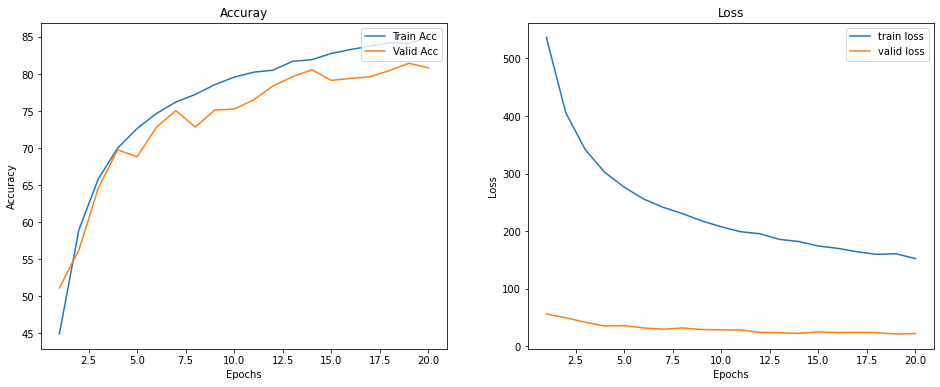

In [ ]:


fig = plt.figure(figsize=(16,6))

plt.subplot(121)
plt.plot(np.arange(1,NUM_EPOCHS+1),train_acc_array)
plt.plot(np.arange(1,NUM_EPOCHS+1),val_acc_array)
plt.title("Accuray")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Acc","Valid Acc"],loc = "upper right")


plt.subplot(122)
plt.plot(np.arange(1,NUM_EPOCHS+1,dtype=int),train_loss_array)
plt.plot(np.arange(1,NUM_EPOCHS+1,dtype=int),val_loss_array)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train loss', 'valid loss'], loc="upper right")

plt.show()

In [ ]:
# can you create a subset of params exclusing pruned weights ?

<h2>Automatic Hyperparameter Search using Optuna</h2>

In [31]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.1 MB/s 
     |████████████████████████████████| 81 kB 10.1 MB/s 
     |████████████████████████████████| 209 kB 60.6 MB/s 
     |████████████████████████████████| 78 kB 8.3 MB/s 
     |████████████████████████████████| 50 kB 5.6 MB/s 
     |████████████████████████████████| 112 kB 54.4 MB/s 
     |████████████████████████████████| 147 kB 65.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=2617ae5bf5e5f9a30d5c74a30b3b5cac665fe7770bd714b755fc746da344879d
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [32]:
import optuna

In [35]:
def objective(trial):

  # generate a model
  model = ResNet18().to(device)

  prune_model(model)

  # trying different optimizers: SGD, Adam, Adadelta, Adagrad
  optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam", "Adadelta","Adagrad"])
  momentum = trial.suggest_float("momentum", 0.0, 1.0)
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
  curr_batch_size = trial.suggest_int("batch_size", 64, 256, step=64)

  # defining a loss function
  criterion = nn.CrossEntropyLoss()

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

  trainloader = torch.utils.data.DataLoader(
    train_ds, batch_size=curr_batch_size, shuffle=True, num_workers=2, drop_last=True)

  val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=curr_batch_size, shuffle=True, num_workers=2, drop_last=True)

  testloader = torch.utils.data.DataLoader(
    testset, batch_size=curr_batch_size, shuffle=False, num_workers=2, drop_last=True)  
  
  NUM_EPOCHS = 35

  for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
      train(epoch)
      accuracy = evaluate(epoch)
      scheduler.step()
      # print("Accuracy ", accuracy)
      # print("epoch ", epoch)
      trial.report(accuracy, epoch)

      if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

  return accuracy

In [ ]:
# TODO: link database to the Optuna study

In [ ]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), study_name="resNet-18")

study.optimize(objective, n_trials = 30)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2022-11-19 00:51:53,634] A new study created in memory with name: resNet-18



Epoch: 0
 [======>]  Step: 342ms | Tot: 23s474ms | Train Loss: 1.782 | Train Acc: 34.271% (15422/45000) 352/352 
 [======>]  Step: 68ms | Tot: 2s675ms | Valid Loss: 1.563 | Valid Acc: 42.960% (2148/5000) 40/40 
Saving..

Epoch: 1


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 [======>]  Step: 39ms | Tot: 24s757ms | Train Loss: 1.295 | Train Acc: 53.484% (24068/45000) 352/352 
 [======>]  Step: 11ms | Tot: 2s203ms | Valid Loss: 1.522 | Valid Acc: 49.360% (2468/5000) 40/40 
Saving..

Epoch: 2
 [======>]  Step: 39ms | Tot: 23s771ms | Train Loss: 1.068 | Train Acc: 62.231% (28004/45000) 352/352 
 [======>]  Step: 12ms | Tot: 2s250ms | Valid Loss: 1.161 | Valid Acc: 58.680% (2934/5000) 40/40 
Saving..

Epoch: 3
 [======>]  Step: 36ms | Tot: 23s893ms | Train Loss: 0.928 | Train Acc: 67.396% (30328/45000) 352/352 
 [======>]  Step: 13ms | Tot: 2s224ms | Valid Loss: 1.116 | Valid Acc: 62.020% (3101/5000) 40/40 
Saving..

Epoch: 4
 [======>]  Step: 37ms | Tot: 23s187ms | Train Loss: 0.846 | Train Acc: 70.336% (31651/45000) 352/352 
 [======>]  Step: 13ms | Tot: 2s506ms | Valid Loss: 0.961 | Valid Acc: 66.140% (3307/5000) 40/40 
Saving..

Epoch: 5
 [======>]  Step: 39ms | Tot: 23s383ms | Train Loss: 0.781 | Train Acc: 72.727% (32727/4

[I 2022-11-19 01:07:31,956] Trial 0 finished with value: 82.8 and parameters: {'optimizer': 'SGD', 'momentum': 0.07654158383381116, 'lr': 4.4993780693007834e-05, 'batch_size': 64}. Best is trial 0 with value: 82.8.



Epoch: 0
 [======>]  Step: 38ms | Tot: 24s140ms | Train Loss: 0.368 | Train Acc: 87.204% (39242/45000) 352/352 
 [======>]  Step: 12ms | Tot: 2s288ms | Valid Loss: 0.500 | Valid Acc: 82.800% (4140/5000) 40/40 

Epoch: 1
 [======>]  Step: 37ms | Tot: 25s46ms | Train Loss: 0.359 | Train Acc: 87.589% (39415/45000) 352/352 
 [======>]  Step: 10ms | Tot: 2s278ms | Valid Loss: 0.531 | Valid Acc: 82.260% (4113/5000) 40/40 

Epoch: 2
 [======>]  Step: 41ms | Tot: 24s345ms | Train Loss: 0.352 | Train Acc: 87.864% (39539/45000) 352/352 
 [======>]  Step: 11ms | Tot: 2s488ms | Valid Loss: 0.455 | Valid Acc: 83.960% (4198/5000) 40/40 
Saving..

Epoch: 3
 [======>]  Step: 38ms | Tot: 23s458ms | Train Loss: 0.351 | Train Acc: 87.784% (39503/45000) 352/352 
 [======>]  Step: 11ms | Tot: 2s222ms | Valid Loss: 0.527 | Valid Acc: 82.020% (4101/5000) 40/40 

Epoch: 4
 [======>]  Step: 38ms | Tot: 24s405ms | Train Loss: 0.347 | Train Acc: 87.980% (39591/45000) 352/352 

[I 2022-11-19 01:23:18,927] Trial 1 finished with value: 85.48 and parameters: {'optimizer': 'SGD', 'momentum': 0.6672748982980846, 'lr': 0.00010817088395568206, 'batch_size': 192}. Best is trial 1 with value: 85.48.



Epoch: 0
 [======>]  Step: 40ms | Tot: 24s863ms | Train Loss: 0.281 | Train Acc: 90.318% (40643/45000) 352/352 
 [======>]  Step: 11ms | Tot: 2s412ms | Valid Loss: 0.467 | Valid Acc: 84.900% (4245/5000) 40/40 

Epoch: 1
 [======>]  Step: 39ms | Tot: 24s72ms | Train Loss: 0.282 | Train Acc: 90.042% (40519/45000) 352/352 
 [======>]  Step: 15ms | Tot: 2s231ms | Valid Loss: 0.439 | Valid Acc: 85.380% (4269/5000) 40/40 

Epoch: 2
 [======>]  Step: 41ms | Tot: 23s812ms | Train Loss: 0.282 | Train Acc: 90.351% (40658/45000) 352/352 
 [======>]  Step: 11ms | Tot: 2s238ms | Valid Loss: 0.433 | Valid Acc: 85.440% (4272/5000) 40/40 

Epoch: 3
 [======>]  Step: 37ms | Tot: 24s177ms | Train Loss: 0.278 | Train Acc: 90.409% (40684/45000) 352/352 
 [======>]  Step: 12ms | Tot: 2s279ms | Valid Loss: 0.451 | Valid Acc: 84.820% (4241/5000) 40/40 

Epoch: 4
 [======>]  Step: 37ms | Tot: 23s982ms | Train Loss: 0.281 | Train Acc: 90.282% (40627/45000) 352/352 
 [======

[I 2022-11-19 01:39:07,557] Trial 2 finished with value: 85.42 and parameters: {'optimizer': 'Adadelta', 'momentum': 0.9766171861231084, 'lr': 0.08722500442910044, 'batch_size': 64}. Best is trial 1 with value: 85.48.



Epoch: 0
 [======>]  Step: 36ms | Tot: 24s603ms | Train Loss: 0.258 | Train Acc: 91.036% (40966/45000) 352/352 
 [======>]  Step: 10ms | Tot: 2s249ms | Valid Loss: 0.404 | Valid Acc: 86.320% (4316/5000) 40/40 
Saving..

Epoch: 1
 [======>]  Step: 39ms | Tot: 23s504ms | Train Loss: 0.257 | Train Acc: 91.140% (41013/45000) 352/352 
 [======>]  Step: 9ms | Tot: 2s216ms | Valid Loss: 0.556 | Valid Acc: 83.520% (4176/5000) 40/40 

Epoch: 2
 [======>]  Step: 38ms | Tot: 24s438ms | Train Loss: 0.260 | Train Acc: 90.978% (40940/45000) 352/352 
 [======>]  Step: 11ms | Tot: 2s283ms | Valid Loss: 0.434 | Valid Acc: 85.540% (4277/5000) 40/40 

Epoch: 3
 [======>]  Step: 40ms | Tot: 24s528ms | Train Loss: 0.257 | Train Acc: 91.013% (40956/45000) 352/352 
 [======>]  Step: 12ms | Tot: 2s295ms | Valid Loss: 0.426 | Valid Acc: 85.960% (4298/5000) 40/40 

Epoch: 4
 [======>]  Step: 39ms | Tot: 24s55ms | Train Loss: 0.254 | Train Acc: 91.202% (41041/45000) 352/352 


[I 2022-11-19 01:54:59,025] Trial 3 finished with value: 84.82 and parameters: {'optimizer': 'Adagrad', 'momentum': 0.6502301545622698, 'lr': 0.0005198707758856726, 'batch_size': 128}. Best is trial 1 with value: 85.48.



Epoch: 0
 [======>]  Step: 38ms | Tot: 26s511ms | Train Loss: 0.251 | Train Acc: 91.307% (41088/45000) 352/352 
 [======>]  Step: 15ms | Tot: 2s543ms | Valid Loss: 0.449 | Valid Acc: 85.320% (4266/5000) 40/40 

Epoch: 1
 [======>]  Step: 40ms | Tot: 24s98ms | Train Loss: 0.241 | Train Acc: 91.698% (41264/45000) 352/352 
 [======>]  Step: 10ms | Tot: 2s271ms | Valid Loss: 0.484 | Valid Acc: 84.580% (4229/5000) 40/40 

Epoch: 2
 [======>]  Step: 38ms | Tot: 24s256ms | Train Loss: 0.241 | Train Acc: 91.591% (41216/45000) 352/352 
 [======>]  Step: 13ms | Tot: 2s270ms | Valid Loss: 0.419 | Valid Acc: 86.220% (4311/5000) 40/40 

Epoch: 3
 [======>]  Step: 35ms | Tot: 24s195ms | Train Loss: 0.245 | Train Acc: 91.478% (41165/45000) 352/352 
 [======>]  Step: 13ms | Tot: 2s220ms | Valid Loss: 0.404 | Valid Acc: 86.840% (4342/5000) 40/40 

Epoch: 4
 [======>]  Step: 40ms | Tot: 24s195ms | Train Loss: 0.237 | Train Acc: 91.820% (41319/45000) 352/352 
 [======

In [ ]:
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
df.tail(5)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_contour(study, params=['batch_size', 'lr'])

In [ ]:
optuna.visualization.plot_param_importances(study)